# HW3
Connor Blake

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import QM9
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

## 1.

### a)

In [6]:
dataset = QM9(root='data/QM9')
print(f"Number of molecules: {len(dataset)}")

data = dataset[0]
print("Node features:", data.x.shape)
print("Edge index:", data.edge_index.shape)
print("Edge attributes:", data.edge_attr.shape)
print("Coordinates:", data.pos.shape)
print("Targets vector:", data.y.shape)

Number of molecules: 130831
Node features: torch.Size([5, 11])
Edge index: torch.Size([2, 8])
Edge attributes: torch.Size([8, 4])
Coordinates: torch.Size([5, 3])
Targets vector: torch.Size([1, 19])


In [7]:
feature_names = [
    "mu (D)",
    "alpha (Bohr^3)",
    "homo (Hartree)",
    "lumo (Hartree)",
    "homo-lumo gap (Hartree)",
    "r2 (Bohr^2)",
    "zpve (Hartree)",
    "u0 (Hartree)",
    "u298 (Hartree)",
    "h298 (Hartree)",
    "g298 (Hartree)",
    "cv (cal/(mol*K))",
    "u0_atom (kcal/mol)",
    "u298_atom (kcal/mol)",
    "h298_atom (kcal/mol)",
    "g298_atom (kcal/mol)",
    "A (GHz)",
    "B (GHz)",
    "C (GHz)",
]

In [8]:
y = torch.stack([d.y for d in dataset], dim=0).squeeze()
print(y.shape)
y_dip = y[:,0]
print(y_dip.shape)

torch.Size([130831, 19])
torch.Size([130831])


In [9]:
print(y_dip.min())

tensor(0.)


In [10]:
y_min = y.min(dim=0).values
y_max = y.max(dim=0).values
y_mean = y.mean(dim=0)
y_median = y.median(dim=0).values
y_std = y.std(dim=0)
stats = torch.stack([y_min, y_max, y_mean, y_median, y_std], dim=1)
print(stats.shape)

torch.Size([19, 5])


In [11]:
for i, name in enumerate(feature_names):
    mn, mx, mean, median, sd = stats[i,:].tolist()
    print(f"{name}: min={mn:.4f}, max={mx:.4f}, median={median:.4f}, mean={mean:.4f}, sd={sd:.4f}")


mu (D): min=0.0000, max=29.5564, median=2.4753, mean=2.6730, sd=1.5035
alpha (Bohr^3): min=6.3100, max=196.6200, median=75.6000, mean=75.2812, sd=8.1738
homo (Hartree): min=-11.6628, max=-2.7674, median=-6.5607, mean=-6.5365, sd=0.5977
lumo (Hartree): min=-4.7620, max=5.2654, median=0.3429, mean=0.3220, sd=1.2749
homo-lumo gap (Hartree): min=0.6694, max=16.9282, median=6.8083, mean=6.8585, sd=1.2842
r2 (Bohr^2): min=19.0002, max=3374.7532, median=1147.2211, mean=1189.4105, sd=280.4781
zpve (Hartree): min=0.4340, max=7.4544, median=4.0444, mean=4.0569, sd=0.9017
u0 (Hartree): min=-19444.3867, max=-1101.4878, median=-11341.9365, mean=-11178.9668, sd=1085.5787
u298 (Hartree): min=-19444.1719, max=-1101.4098, median=-11341.7197, mean=-11178.7354, sd=1085.5728
h298 (Hartree): min=-19444.1465, max=-1101.3840, median=-11341.6943, mean=-11178.7100, sd=1085.5728
g298 (Hartree): min=-19445.3145, max=-1102.0229, median=-11342.8301, mean=-11179.8750, sd=1085.5924
cv (cal/(mol*K)): min=6.0020, max=

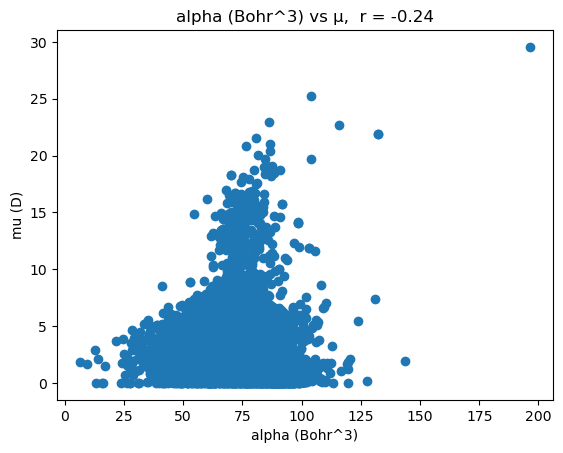

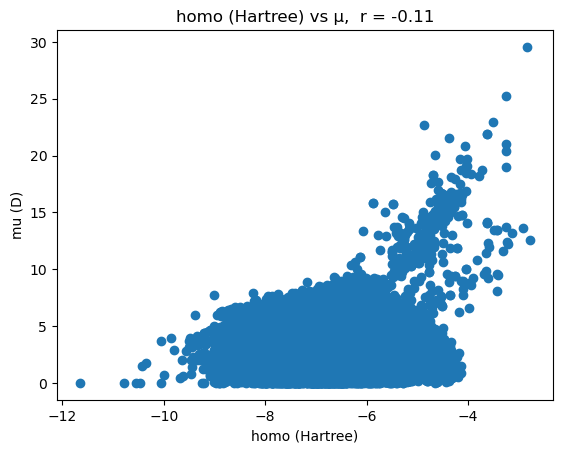

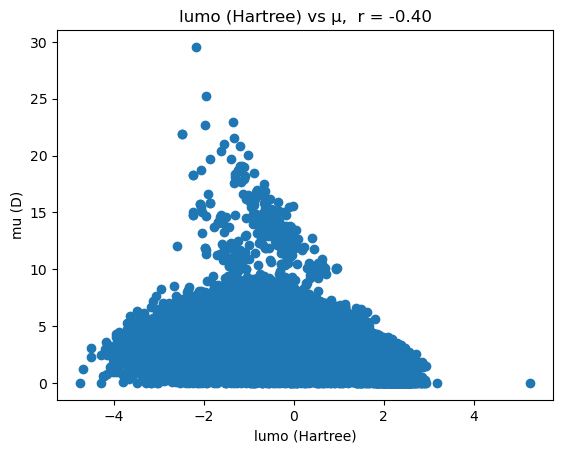

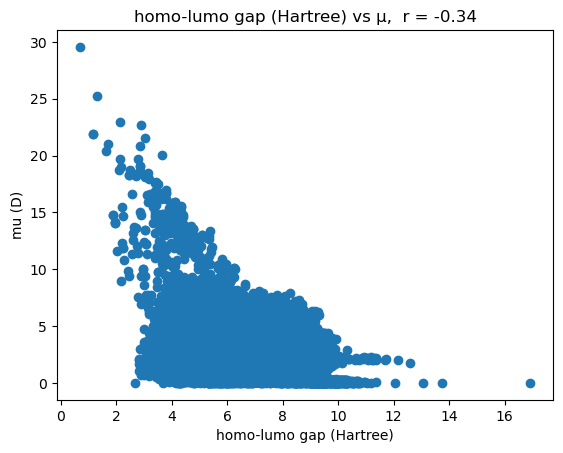

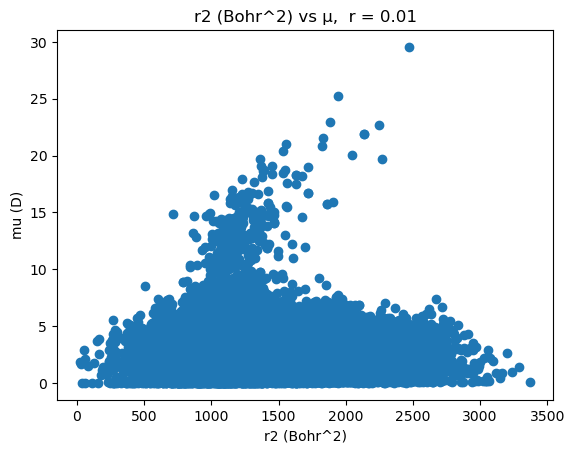

In [12]:
feature_indices = [1, 2, 3, 4, 5]  # alpha, homo, lumo, gap, r2
for idx in feature_indices:
    name = feature_names[idx]
    x = y[:, idx]
    corr = np.corrcoef(x, y_dip)[0, 1]
    plt.figure()
    plt.scatter(x, y_dip)
    plt.xlabel(name)
    plt.ylabel("mu (D)")
    plt.title(f"{name} vs μ,  r = {corr:.2f}")
    plt.show()

### b)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
dip_mean = y_dip.mean()
dip_std = y_dip.std()
y_dip_norm = (y_dip - dip_mean) / dip_std
print("Original: ",dip_mean,dip_std)
print("Normed:",y_dip_norm.mean(), y_dip_norm.std())

Original:  tensor(2.6730) tensor(1.5035)
Normed: tensor(-1.7389e-07) tensor(1.)


In [15]:
indices = np.arange(10000)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=0)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=0)

train_ds = dataset[train_idx]
val_ds   = dataset[val_idx]
test_ds  = dataset[test_idx]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)
test_loader  = DataLoader(test_ds,  batch_size=32)


## 2.

### a)

In [16]:
from torch.nn import Sequential as Sequential, Linear, ReLU, BatchNorm1d, Module
from torch_scatter import scatter

In [17]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=24, edge_dim=4, aggr='add'):
        # message dim = R^d
        # edge info dim = R^{d_e}
        # node info dim = R^{d_n}
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # phi_e: d x d x d_e -> d
        self.phi_e = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # phi_h: d x d -> d
        self.phi_h = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.phi_e(msg)
    
    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.phi_h(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')
    
    # TODO

In [25]:
def permute_graph(data, perm):
    data.x = data.x[perm]
    data.pos = data.pos[perm]
    data.z = data.z[perm]
    data.batch = data.batch[perm]

    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]
    return data

def permutation_invariance_unit_test(module, dataloader):
    it = iter(dataloader)
    data = next(it)

    data.edge_attr = torch.zeros(data.edge_attr.shape)
    out_1 = module(data)
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)
    out_2 = module(data)
    return torch.allclose(out_1, out_2, atol=1e-04)

def permutation_equivariance_unit_test(module, dataloader):
    it = iter(dataloader)
    data = next(it)
    data.edge_attr = torch.zeros(data.edge_attr.shape)
    out_1 = module(data.x, data.edge_index, data.edge_attr)
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)
    out_2 = module(data.x, data.edge_index, data.edge_attr)
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

In [26]:
layer = MPNNLayer(emb_dim=11, edge_dim=4)
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, train_loader)}!")

Is MPNNLayer permutation equivariant? --> True!


Layer Equivariance to Permutations:
The MPNN layer is equivariant to permutations:
The MPNN update from 2a becomes  
$$
h^{l+1}_i \;=\;\phi_h\Bigl(h^l_i,\;\sum_{j\in\mathcal{N}(i)}\phi_e\bigl(h^l_i,h^l_j,e_{ij}\bigr)\Bigr).
$$

Under a permutation $\rho$ acting on the outer index $i$, we compute  
$$
h^{l+1}_{\rho(i)}
=\phi_h\Bigl(h^l_{\rho(i)},\sum_{j\in\mathcal{N}(\rho(i))}\phi_e\bigl(h^l_{\rho(i)},h^l_j,e_{\rho(i)j}\bigr)\Bigr).
$$

Noting that $\mathcal{N}(\rho(i))=\{\rho(k)\mid k\in\mathcal{N}(i)\}$, let $j=\rho(k)$. Then  
$$
\sum_{j\in\mathcal{N}(\rho(i))}\phi_e\bigl(h^l_{\rho(i)},h^l_j,e_{\rho(i)j}\bigr)
=\sum_{k\in\mathcal{N}(i)}\phi_e\bigl(h^l_{\rho(i)},h^l_{\rho(k)},e_{\rho(i)\rho(k)}\bigr).
$$

Hence  
$$
h^{l+1}_{\rho(i)}
=\phi_h\Bigl(h^l_{\rho(i)},\sum_{k\in\mathcal{N}(i)}\phi_e\bigl(h^l_{\rho(i)},h^l_{\rho(k)},e_{\rho(i)\rho(k)}\bigr)\Bigr)
=\rho\bigl(h^{l+1}_i\bigr),
$$

showing that the MPNN layer is equivariant under any permutation $\rho\!$. 

### b)

In [27]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """
        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # W_in: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        self.pool = global_mean_pool

        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            (PyG.Data) -> (batch_size, out_dim)
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)
        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [28]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, train_loader)}!")

Is MPNNModel permutation invariant? --> True!


### c)

In [32]:
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = MPNNModel(num_layers=4, emb_dim=24, in_dim=11, edge_dim=4, out_dim=1)

In [33]:
allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H", 
    "Unknown",
]
def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"

def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

In [34]:
def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol

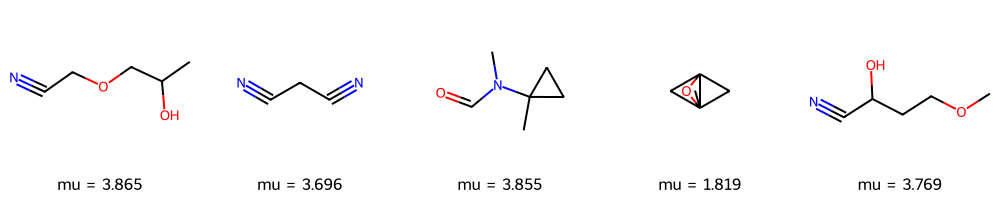

In [35]:
num_viz = 5
mols = [to_rdkit(train_ds[i]) for i in range(num_viz)]
values = [str(round(float(train_ds[i].y.squeeze()[0]), 3)) for i in range(num_viz)]

Chem.Draw.MolsToGridImage(mols, legends=[f"mu = {value}" for value in values], molsPerRow=5)

In [36]:
import time
import torch.nn.functional as functional

In [37]:
def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = functional.mse_loss(y_pred, data.y[:,0])
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * dip_std - data.y[:,0] * dip_std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # raw test train error
        train_error = eval(model, train_loader, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
            f'Train MAE: {train_error:3f}, Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((train_error, test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

In [38]:
import pandas as pd

In [40]:
model = MPNNModel(num_layers=4, emb_dim=32, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

Running experiment for MPNNModel, training on 7200 samples for 100 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=11, out_features=32, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=32, aggr=add)
  )
  (lin_pred): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 27041

Start training:
Epoch: 001, LR: 0.001000, Loss: 1.6458489, Train MAE: 1.404175, Val MAE: 1.3939503, Test MAE: 1.4040138
Epoch: 002, LR: 0.001000, Loss: 1.4812613, Train MAE: 1.400218, Val MAE: 1.4057600, Test MAE: 1.4040138
Epoch: 003, LR: 0.001000, Loss: 1.3001839, Train MAE: 1.195983, Val MAE: 1.2135205, Test MAE: 1.1962913
Epoch: 004, LR: 0.001000, Loss: 1.1576156, Train MAE: 1.144498, Val MAE: 1.2179030, Test MAE: 1.1962913
Epoch: 005, LR: 0.001000, Loss: 1.0932607, Train MAE: 1.034591, Val MAE: 1.0552772, Test MAE: 1.0467450
Epoch: 006, LR: 0.001000, Loss: 0.9389542, Train MAE: 1.012597, Val MAE: 1.0354850, Test MAE: 1.0174816
Epoch: 007, LR: 0.001000,

In [41]:
torch.save(model.state_dict(), 'mpnn_state_dict_q2.pth')

Text(0, 0.5, 'MAE')

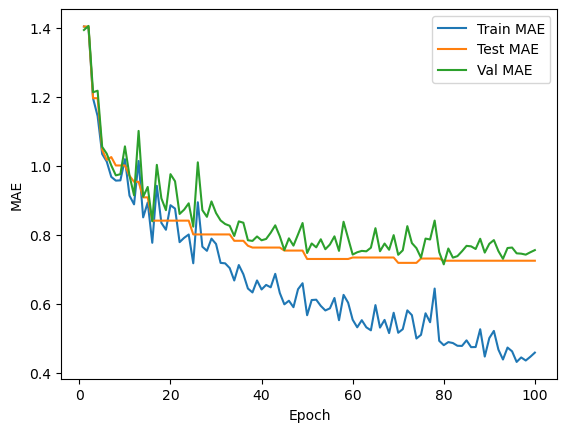

In [55]:
perf = np.array(perf_per_epoch)
perf = perf[:, :-1].astype(float)
plt.plot(perf[:,3],perf[:,0],label="Train MAE")
plt.plot(perf[:,3],perf[:,1],label="Test MAE")
plt.plot(perf[:,3],perf[:,2],label="Val MAE")
plt.xlabel("Epoch")
plt.legend()
plt.ylabel("MAE")

## 3.

### a)

In [ ]:
class CoordMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # ============ YOUR CODE HERE ==============
        # Adapt the input linear layer or add new input layers 
        # to account for the atom positions.
        #
        # Linear projection for initial node features and coordinates
        # dim: (d_n + 3) -> d
        # self.lin_in = ...
        # ==========================================
        self.lin_in = Linear(in_dim + 3, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        # ============ YOUR CODE HERE ==============
        # Incorporate the atom positions along with the features.
        #
        # h = ...
        # ==========================================
        h = self.lin_in(torch.cat([data.x, data], dim=-1))
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)